#Mount drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/"

cpsc_leadclass_balanced_labels.npy  gtdata_lead_4.npy  labels_lead2.npy
cpsc_leadclass_balanced.npy	    gtdata_lead_5.npy  labels_lead3.npy
ecgsrcnn_250_labels.npy		    gtdata_lead_6.npy  labels_lead4.npy
ecgsrcnn_250op.npy		    gtdata_lead_7.npy  labels_lead5.npy
gtdata_lead_0.npy		    gtdata_lead_8.npy  labels_lead6.npy
gtdata_lead_10.npy		    gtdata_lead_9.npy  labels_lead7.npy
gtdata_lead_11.npy		    labels_lead0.npy   labels_lead8.npy
gtdata_lead_1.npy		    labels_lead10.npy  labels_lead9.npy
gtdata_lead_2.npy		    labels_lead11.npy
gtdata_lead_3.npy		    labels_lead1.npy


In [ ]:
!ls "/content/drive/My Drive/Leadwise_data"

gtdata_lead_0.npy   gtdata_lead_1.npy  gtdata_lead_4.npy  gtdata_lead_7.npy
gtdata_lead_10.npy  gtdata_lead_2.npy  gtdata_lead_5.npy  gtdata_lead_8.npy
gtdata_lead_11.npy  gtdata_lead_3.npy  gtdata_lead_6.npy  gtdata_lead_9.npy


#Accessing  data directly from drive

In [ ]:
#This is for the imbalanced dataset 
import numpy as np

gt_ecg_data = np.load("/content/drive/My Drive/gt_set.npy")
down_250_ecg_set = np.load("/content/drive/My Drive/down250_set.npy")

print(len(gt_ecg_data))
print(gt_ecg_data.dtype)
print(gt_ecg_data.shape)

82524


dtype('float32')

In [ ]:
#This is for the balanced dataset 

import numpy as np
from scipy.signal import resample_poly

down_250set = []
down_125set = []
down_100set = []

gt_data = np.load("/content/drive/My Drive/Leadwise_data/cpsc_leadclass_balanced.npy")
lead_output_labels = np.load("/content/drive/My Drive/Leadwise_data/cpsc_leadclass_balanced_labels.npy")

for entry in gt_data:
  down_250set.append(resample_poly(entry,up=250,down=500))
  down_125set.append(resample_poly(entry,up=125,down=500))
  down_100set.append(resample_poly(entry,up=100,down=500))

In [ ]:
down_ecg_set = np.array(down_100set)

In [ ]:
import numpy as np

cpsc_labels = lead_output_labels

In [ ]:
print(len(gt_data))
print(len(down_ecg_set))
print(len(cpsc_labels))

21816
21816
21816


In [ ]:
temp = list(zip(gt_data,cpsc_labels))

In [ ]:
len(temp)

21816

##Restrict to 5 classes

Required only for ablation study

In [ ]:
import numpy as np

gt_ecg_data = gt_data[:4622]
down_250_ecg_set = np.array(down_250set[:4622])

In [ ]:
print(gt_ecg_data.shape)
print(down_250_ecg_set.shape)

(4622, 3000)
(4622, 1500)


##Data split-balanced

In [ ]:
from sklearn.utils import shuffle

X_shuffled,y_shuffled = shuffle(down_ecg_set,temp, random_state=42)
down_final = X_shuffled[:1500]
gt_final = y_shuffled[:1500]

In [ ]:
from sklearn.model_selection import train_test_split

down_ecg_train, X_test_temp, gt_set_train, y_test_temp = train_test_split(down_final, gt_final, test_size=0.3, random_state=42)

down_ecg_validate,down_ecg_test,gt_set_validate,gt_set_test = train_test_split(X_test_temp,y_test_temp,test_size=0.5, random_state=42)

In [ ]:
down_ecg_train.shape

(1050, 600)

#Network


###Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, UpSampling1D
from tensorflow.keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU, Subtract, Reshape
from IPython.display import SVG
from keras.layers.core import Activation
from tensorflow.keras.optimizers import Adam, SGD

from time import time
import numpy as np

##ECG-SRCNN


Ths is the final network that is utilised for performing the super-resolution task.

In [ ]:
def net_sr(input_shape=(1500,1), n_classes=1,scale_param=2):
  input = Input(input_shape)
  x = input
  x1 = UpSampling1D(size=scale_param)(x)
  x2 = Conv1D(64, 9, kernel_initializer = "he_normal",padding='same')(x1)
  x2 = Activation("relu")(x2)
  x2 = Conv1D(64, 9, kernel_initializer = "he_normal",padding='same')(x2)
  x2 = Activation("relu")(x2)
  x2 = Conv1D(32, 1, kernel_initializer = "he_normal",padding='same')(x2)
  x2 = Activation("relu")(x2)
  x2 = Conv1D(32, 1, kernel_initializer = "he_normal",padding='same')(x2)
  x2 = Activation("relu")(x2)
  x2 = Conv1D(1, 5, kernel_initializer = "he_normal",padding='same')(x2)
  x2 = Activation("relu")(x2)
  x3 = Add()([x1,x2])
  output = Dense(n_classes)(x3)
  model = Model(input, output)
  return model

##1D-SRCNN

This network was the starting point in the development of ECG-SRCNN. This is also utilized for the ablation/performance comparison study.

In [ ]:
def new_net_sr(input_shape=(1500,1), n_classes=1,scale_param=2):
  input = Input(input_shape)
  x = input
  x1 = UpSampling1D(size=scale_param)(x)
  x2 = Conv1D(64, 9, kernel_initializer = "he_normal",padding='same')(x1)
  x2 = Activation("relu")(x2)
  x2 = Conv1D(32, 1, kernel_initializer = "he_normal",padding='same')(x2)
  x2 = Activation("relu")(x2)
  x2 = Conv1D(1, 5, kernel_initializer = "he_normal",padding='same')(x2)
  x2 = Activation("relu")(x2)
  x3 = Add()([x1,x2])
  output = Dense(n_classes)(x3)
  model = Model(input, output)
  return model

##Get model

In [ ]:
K.clear_session()
input_shape = (600, 1)
new_model = net_sr(input_shape = input_shape,scale_param=5)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
up_sampling1d (UpSampling1D)    (None, 3000, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3000, 64)     640         up_sampling1d[0][0]              
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 3000, 64)     0           conv1d[0][0]                     
______________________________________________________________________________________________

##Compile and train

In [ ]:
gt_train = []
labels_train = []
gt_val = []
labels_val = []
gt_test = []
labels_test = []

for item in gt_set_train:
  gt_train.append(item[0])
  labels_train.append(item[1])

for item in gt_set_validate:
  gt_val.append(item[0])
  labels_val.append(item[1])

for item in gt_set_test:
  gt_test.append(item[0])
  labels_test.append(item[1])

In [ ]:
gt_train = np.array(gt_train)
labels_train = np.array(labels_train)
gt_val = np.array(gt_val)
labels_val = np.array(labels_val)
gt_test = np.array(gt_test)
labels_test = np.array(labels_test)

In [ ]:
opt = Adam(learning_rate = 0.01)
new_model.compile(loss = "mse", optimizer = opt)

In [ ]:
new_model.fit(down_ecg_train,gt_train,epochs=10,batch_size=32,validation_data=(down_ecg_validate, gt_val),verbose = 1)

Epoch 1/10
33/33 [==============================] - 2s 37ms/step - loss: 0.2833 - val_loss: 0.2351
Epoch 2/10
33/33 [==============================] - 1s 21ms/step - loss: 0.2085 - val_loss: 0.1747
Epoch 3/10
33/33 [==============================] - 1s 21ms/step - loss: 0.1541 - val_loss: 0.1251
Epoch 4/10
33/33 [==============================] - 1s 21ms/step - loss: 0.1101 - val_loss: 0.0903
Epoch 5/10
33/33 [==============================] - 1s 21ms/step - loss: 0.0788 - val_loss: 0.0624
Epoch 6/10
33/33 [==============================] - 1s 21ms/step - loss: 0.0547 - val_loss: 0.0440
Epoch 7/10
33/33 [==============================] - 1s 21ms/step - loss: 0.0381 - val_loss: 0.0312
Epoch 8/10
33/33 [==============================] - 1s 22ms/step - loss: 0.0271 - val_loss: 0.0217
Epoch 9/10
33/33 [==============================] - 1s 22ms/step - loss: 0.0196 - val_loss: 0.0159
Epoch 10/10
33/33 [==============================] - 1s 21ms/step - loss: 0.0148 - val_loss: 0.0123


##Saving the model for later usage and plot


In [ ]:
new_model.save('ECG_srcnn_100Hz.h5') 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
import shutil

shutil.move('ECG_srcnn_100Hz.h5', "/content/drive/My Drive/")

'/content/drive/My Drive/ECG_srcnn_100Hz.h5'

In [ ]:
new_model.evaluate(down_ecg_test,gt_test)

8/8 [==============================] - 0s 9ms/step - loss: 0.0135


0.013490697368979454

In [ ]:
sr_output = new_model.predict(down_ecg_test)

0.6184188
-0.2065812


Text(0, 0.5, 'Amplitude')

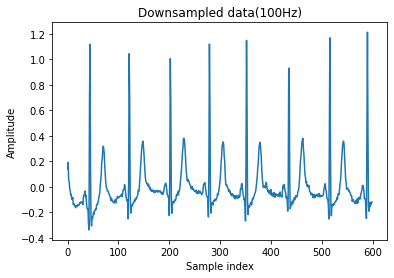

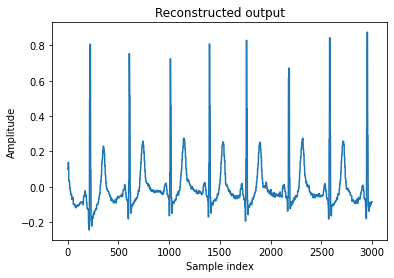

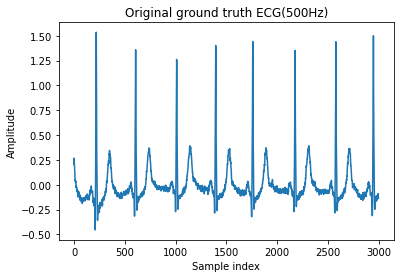

In [ ]:
from matplotlib import pyplot as plt
print(max(gt_test[10]))
print(min(gt_test[10]))

plt.plot(down_ecg_test[20])
plt.title("Downsampled data(100Hz)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.figure()
plt.plot(sr_output[20])
plt.title("Reconstructed output")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.figure()
plt.plot(gt_test[20])
plt.title("Original ground truth ECG(500Hz)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")

##Performance metrics

In [ ]:
from math import sqrt
from scipy.stats.stats import pearsonr

class Evaluator:
    def __init__(self,y_true,y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

    def mean_square_error(self):
        self.y_true = np.asmatrix(self.y_true).reshape(-1)
        self.y_pred = np.asmatrix(self.y_pred).reshape(-1)

        return np.square(np.subtract(self.y_true, self.y_pred)).mean()

    def root_mean_square_error(self):

        return self.mean_square_error()**0.5


    def mean_absolute_percentage_error(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        if len(np.where(self.y_true == 0)[0]) > 0:
            return np.inf
        else:
            return np.mean(np.abs((self.y_true - self.y_pred) / self.y_true)) * 100

    def symmetric_mean_absolute_percentage_error(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        return np.mean(np.abs((self.y_true - self.y_pred) / (( np.abs(self.y_true) + np.abs(self.y_pred) )/2) ))

    def mean_absolute_error(self):
        
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        return np.mean(np.abs(self.y_true - self.y_pred))


    def u_theil(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        error_sup = np.square(np.subtract(self.y_true, self.y_pred)).sum()
        error_inf = np.square(np.subtract(self.y_true[0:(len(self.y_true) - 1)], self.y_true[1:(len(self.y_true))])).sum()

        return error_sup / error_inf


    def average_relative_variance(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)
        mean = np.mean(self.y_true)

        error_sup = np.square(np.subtract(self.y_true, self.y_pred)).sum()
        error_inf = np.square(np.subtract(self.y_true, mean)).sum()

        return error_sup / error_inf


    def index_agreement(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)
        mean = np.mean(self.y_true)

        error_sup = np.square(np.abs(np.subtract(self.y_true, self.y_pred))).sum()

        error_inf = np.abs(np.subtract(self.y_pred, mean)) + np.abs(np.subtract(self.y_true, mean))
        error_inf = np.square(error_inf).sum()

        return 1 - (error_sup / error_inf)


    def prediction_of_change_in_direction(self):
        self.y_true = np.asarray(self.y_true).reshape(-1)
        self.y_pred = np.asarray(self.y_pred).reshape(-1)

        true_sub = np.subtract(self.y_true[0:(len(self.y_true) - 1)], self.y_true[1:(len(self.y_true))])
        pred_sub = np.subtract(self.y_pred[0:(len(self.y_pred) - 1)], self.y_pred[1:(len(self.y_pred))])

        mult = true_sub * pred_sub
        result = 0
        for m in mult:
            if m > 0:
                result = result + 1

        return (100 * (result / len(self.y_true)))


    def pearson_coefficient(self):
        return pearsonr(self.y_pred,self.y_true)[0]

    def snr(self):
        self.y_true = np.asmatrix(self.y_true).reshape(-1)
        self.y_pred = np.asmatrix(self.y_pred).reshape(-1)
        snr = 10 * np.log10(np.square(self.y_true).sum() / np.square(np.subtract(self.y_true, self.y_pred)).sum())
        return snr

    def generate_metric_results(self):
        return {'MSE': self.mean_square_error(),
                'RMSE':self.root_mean_square_error(),
                'MAPE': self.mean_absolute_percentage_error(),
                'SMAPE':self.symmetric_mean_absolute_percentage_error(),
                'MAE': self.mean_absolute_error(),
                'theil': self.u_theil(),
                'ARV': self.average_relative_variance(),
                'IA': self.index_agreement(),
                'POCID': self.prediction_of_change_in_direction(),
                'Pearson': self.pearson_coefficient(),
                'SNR': self.snr() }

In [ ]:
metric_eval = Evaluator(y_true=gt_test[25],y_pred=sr_output[25]) 
dict_metrics_single = metric_eval.generate_metric_results()
print(dict_metrics_single)
all_rmse_op = []

all_pearson_op = []

all_snr_op = []

for i in range(len(sr_output)):
  output_metric_eval = Evaluator(y_true=gt_test[i],y_pred=sr_output[i]) 
  output_dict_metrics = output_metric_eval.generate_metric_results()
  all_rmse_op.append(output_dict_metrics['RMSE'])
  all_pearson_op.append(output_dict_metrics['Pearson'])
  all_snr_op.append(output_dict_metrics['SNR'])

print(
np.mean(np.array(all_rmse_op)), ": RMSE\n",
np.mean(np.array(all_pearson_op)),": mean Pearson coeff output side\n",
np.mean(np.array(all_snr_op)), ": Net SNR"
)

{'MSE': 0.010127495, 'RMSE': 0.10063545619203859, 'MAPE': 42.22944378852844, 'SMAPE': 0.40134913, 'MAE': 0.04519552, 'theil': 6.3918395, 'ARV': 0.19598138, 'IA': 0.931701235473156, 'POCID': 15.0, 'Pearson': 0.9181280727368615, 'SNR': 7.078304290771484}
0.08145640821908438 : RMSE
 0.9214675032235679 : mean Pearson coeff output side
 7.335244009229872 : Net SNR
